In [124]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Flatten, Dense, Reshape, Multiply, Add,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pathlib
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
%matplotlib inline


In [104]:
data = pd.read_csv(r"/content/fer2013.csv")
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [105]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [106]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


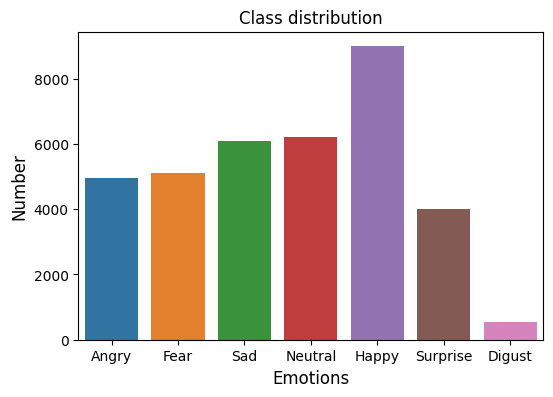

In [107]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.barplot(x=emotion_counts['emotion'], y=emotion_counts['number'])
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

<ipython-input-108-a6517d8c1d2b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


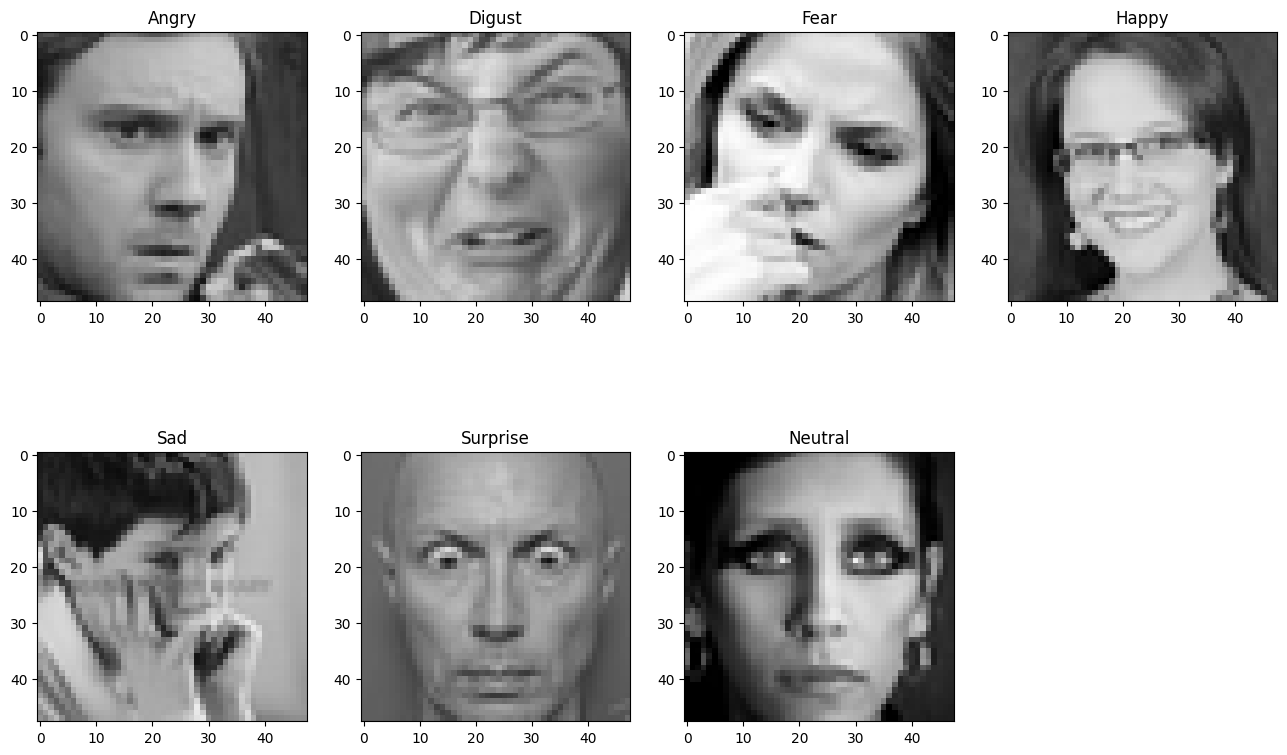

In [108]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [109]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))


train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


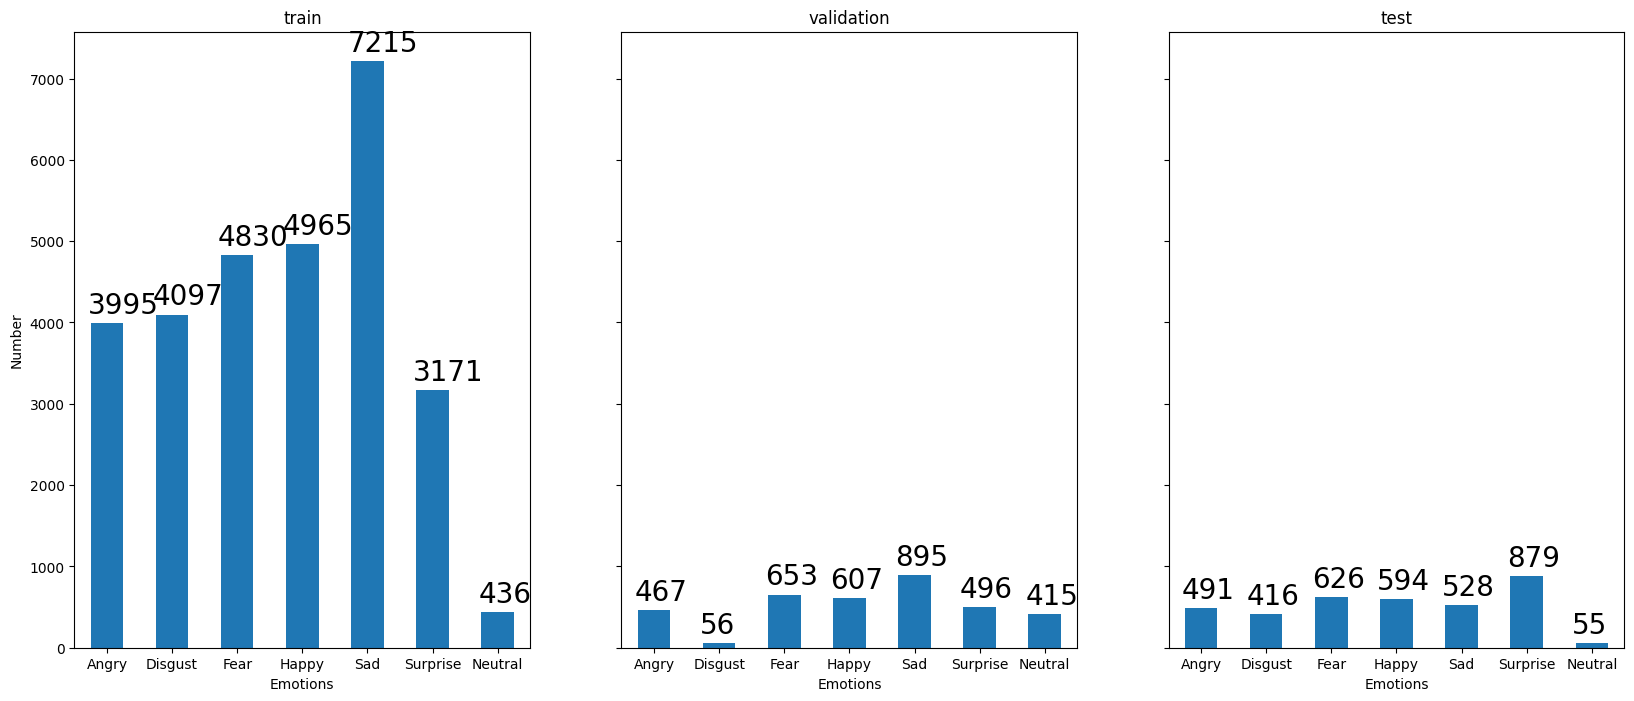

In [127]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    for i in axe.patches:
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=20, color='black',
                    rotation=0)


fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [111]:

width, height = 48, 48

datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

from keras.utils import to_categorical
# Extract the 'emotion' column from your DataFrame
emotion_labels = data['emotion']

# Convert emotion labels to one-hot encoded matrix using Keras to_categorical
y = to_categorical(emotion_labels)

#storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")


Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [126]:

num_features = 64
num_labels = 7
batch_size = 64
epochs = 10
width, height = 48, 48

x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)


#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)
np.save('modXtest', X_test)

In [99]:
#desinging the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

#model.summary()

In [100]:

#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

#saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Epoch 1/10
455/455 [==============================] - 1279s 3s/step - loss: 1.9736 - accuracy: 0.2150 - val_loss: 1.8171 - val_accuracy: 0.2594
Epoch 2/10
455/455 [==============================] - 1261s 3s/step - loss: 1.8312 - accuracy: 0.2504 - val_loss: 1.7770 - val_accuracy: 0.2588
Epoch 3/10
455/455 [==============================] - 1261s 3s/step - loss: 1.7493 - accuracy: 0.2903 - val_loss: 1.5865 - val_accuracy: 0.3384
Epoch 4/10
455/455 [==============================] - 1265s 3s/step - loss: 1.6171 - accuracy: 0.3566 - val_loss: 1.5353 - val_accuracy: 0.4012
Epoch 5/10
455/455 [==============================] - 1253s 3s/step - loss: 1.5268 - accuracy: 0.4015 - val_loss: 1.3769 - val_accuracy: 0.4582
Epoch 6/10
455/455 [==============================] - 1270s 3s/step - loss: 1.4630 - accuracy: 0.4230 - val_loss: 1.3561 - val_accuracy: 0.4619
Epoch 7/10
455/455 [==============================] - 1270s 3s/step - loss: 1.4252 - accuracy: 0.4434 - val_loss: 1.3522 - val_accuracy:

In [120]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

113/113 [==============================] - 35s 313ms/step
CNN Model Accuracy on test set: 0.5057


1/1 [==============================] - 0s 30ms/step


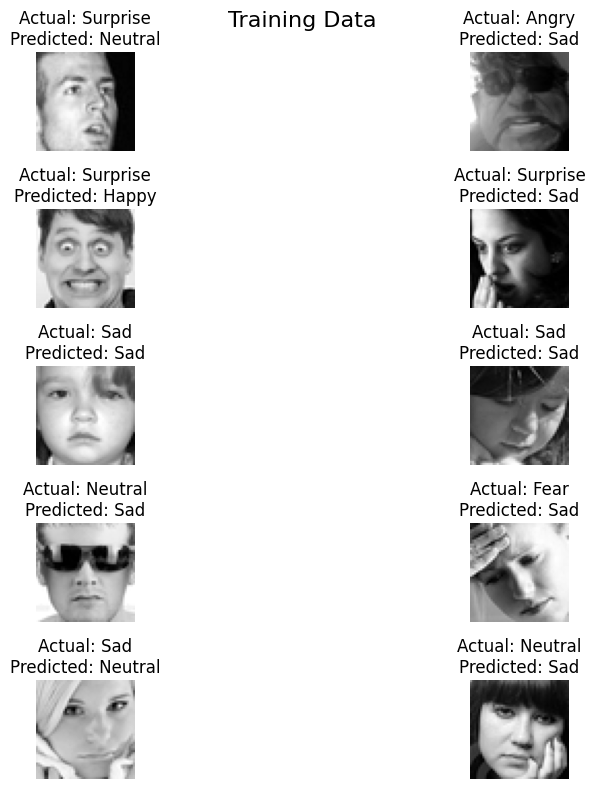

1/1 [==============================] - 0s 28ms/step


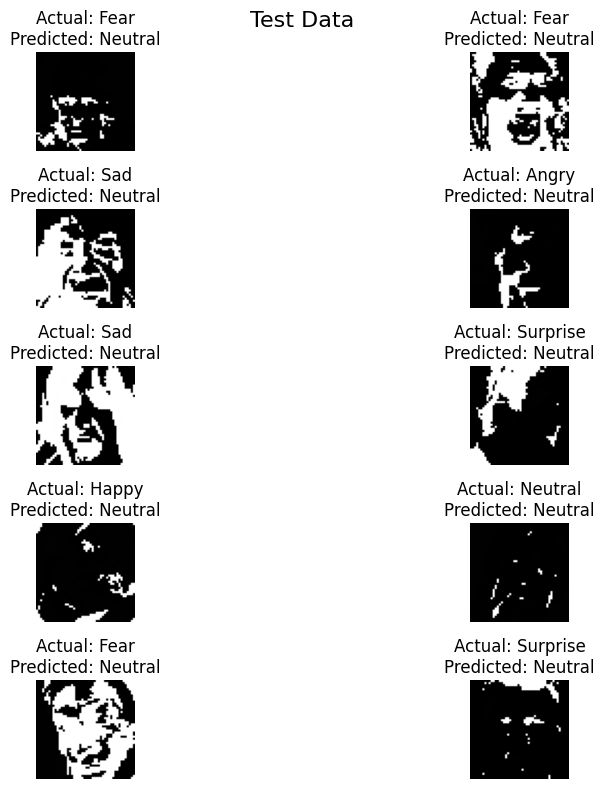

In [152]:

# Load the pre-trained model
with open('fer.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("fer.h5")

# Load your training and test data
X_train = np.load('fdataX.npy')  # Load your training data
y_train = np.load('flabels.npy')  # Load corresponding training labels
X_test = np.load('modXtest.npy')  # Load your test data
y_test = np.load('flabels.npy')  # Load corresponding test labels

# Function to predict emotion on a single image
def predict_emotion(image):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    # Reshape and preprocess the image for prediction
    img = image.reshape(1, 48, 48, 1)
    img = img.astype('float32')
    img /= 255.0  # Normalize image data

    # Predict emotion
    predicted_emotion = loaded_model.predict(img)
    emotion_index = np.argmax(predicted_emotion)
    emotion = emotion_labels[emotion_index]

    return emotion
# Function to display random images with actual and predicted emotions
# Function to display random images with actual and predicted emotions
def display_random_images_with_emotions(data_images, data_labels, num_images=10, title=""):
    plt.figure(figsize=(12, 8))
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    chosen_indices = np.random.choice(len(data_images), num_images, replace=False)

    rows = int(np.ceil(num_images / 2))
    for i, index in enumerate(chosen_indices):
        plt.subplot(rows, 2, i + 1)

        # Preprocess the image
        img = data_images[index].reshape(48, 48)
        img = img.astype(np.uint8)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # Predict emotion
        predicted_emotion = predict_emotion(data_images[index])
        actual_emotion = emotion_labels[np.argmax(data_labels[index])]

        plt.title(f'Actual: {actual_emotion}\nPredicted: {predicted_emotion}')

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display 10 randomly selected training images with actual and predicted emotions
display_random_images_with_emotions(X_train, y_train, num_images=10, title="Training Data")

# Display 10 randomly selected test images with actual and predicted emotions
display_random_images_with_emotions(X_test, y_test, num_images=10, title="Test Data")
